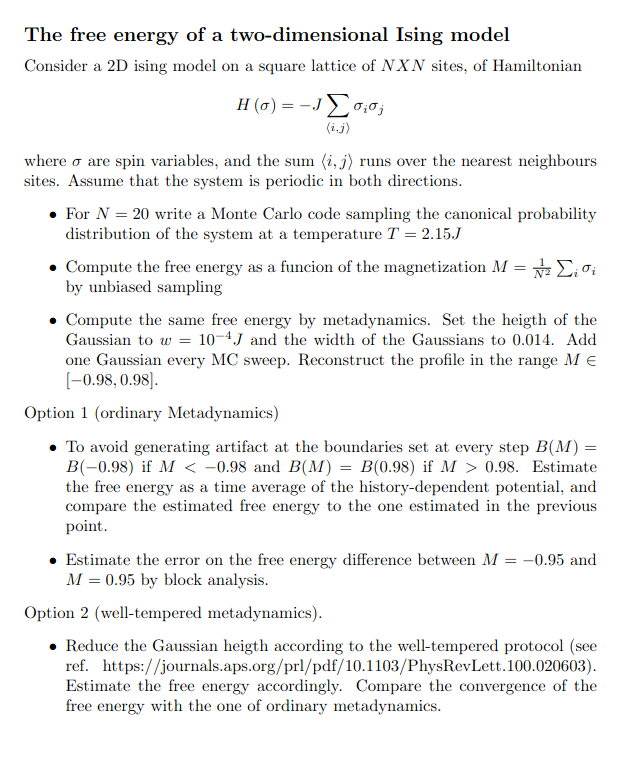

In [264]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [265]:
# Define parameters 
N = 20 # Number of sites along one dimension
J = 1 # Coupling constant
kbT = 2.15*J # Temperature
n_steps = 10000 # Default number of time steps

In [266]:
# Define the Hamiltonian
def H(spins, J):
    ''' Returns the Hamiltonian of the system. It is computed as the sum of the interactions between nearest neighbours. '''
    # Compute interaction with each neighbour in a parallelised fashion by matrices element-wise multiplication. np.roll accounts for PBCs.
    H = spins*np.roll(spins,1, axis=1) + spins*np.roll(spins,-1, axis=1) + spins*np.roll(spins,-1, axis=0) + spins*np.roll(spins,1, axis=0)
    return -J*H/2 # We divide to avoid double counting

# Define magnetisation
def M_compute(spins):
    ''' Returns the total magnetisation of the system, divided by the number of sites. '''
    return np.sum(spins)/N**2

In [267]:
# Metadynamics params
w = 1e-4*J # Height of the Gaussian
width = 0.014 # Width of the Gaussian
M_domain = np.linspace(-1,1,N**2 + 1, endpoint=True) # Domain of the magnetisation

In [268]:
def add_gaussian(bias,M,w,width, gamma):
    ''' Adds a Gaussian centered on M to the bias potential. '''
    # Compute gaussian centered on M on each point of the domain of M
    well_tempered_factor = 1 if gamma is None else np.exp(-get_bias(bias,M)/gamma)
    gaussian = w*np.exp(-(M_domain-M)**2/(2*width**2))*well_tempered_factor
    # Add the Gaussian to the bias potential
    bias += gaussian
    return bias

def get_bias_index(M):
    ''' Returns the index of the bias potential corresponding to the magnetisation M. '''
    # We need to map the magnetization domain to integers. To do so the lowest posible magnetization is associated to 0, the highest to N**2+1
    return np.round((M*N**2 + N**2)/2).astype(int)

def get_bias(bias,M):
    ''' Returns the bias potential for a given magnetisation. '''
    M_index = get_bias_index(M)
    return bias[M_index]

def propose_single_move(spins):
    '''Optimised version of propose move for spins_flip_per_step == 1'''
    ix, iy = np.random.randint(N,size=2)
    delta_E = 2*spins[ix,iy]*(spins[ix,(iy+1)%N] + spins[ix,(iy-1)%N] + spins[(ix+1)%N,iy] + spins[(ix-1)%N,iy])
    delta_M = -2*spins[ix,iy]/N**2
    return (ix,iy), delta_E, delta_M

def propose_move(spins, spins_flip_per_step):
    '''Proposes a move by flipping random spins. Number of spins flipped is given by spins_flip_per_step.
     Returns the proposed spins, energy and magnetisation. '''
    if spins_flip_per_step == 1:
        # Optimised version for spins_flip_per_step == 1
        return propose_single_move(spins)
 
    proposed_spins = spins.copy()
    # Randomly choose the spins to flip
    # Generate N couples of random integers between 0 and N-1
    ijs = np.random.randint(N, size=(spins_flip_per_step,2))
    for i,j in ijs:
        proposed_spins[i,j] *= -1
    
    # Compute the new energy and magnetisation
    delta_E = np.sum(H(proposed_spins, J)) - np.sum(H(spins, J))
    delta_M = M_compute(proposed_spins) - M_compute(spins)
    return ijs, delta_E, delta_M

def initialize(metadynamics, bias, spins, M_time_series, B_time_series):
    ''' Initializes the E_0, M, M_time_series and bias. If metadynamics is True, initializes the bias potential. '''
    if metadynamics:
        # Raise error if only one is given between bias and spins
        if (bias is None) != (spins is None) != (M_time_series is None):
            raise ValueError('If metadynamics is True, both bias and spins must be given or none of them.')
    
    if spins is None:
        spins = np.random.choice([-1,1], size=(N,N)) # Random initial configuration
    
    M = M_compute(spins) # Initial magnetisation
    if M_time_series is None:
        M_time_series = [ M_compute(spins), ] # List to store the magnetisation at each time step
    elif type(M_time_series) == np.ndarray:
        M_time_series = list(M_time_series)

    E_0 = np.sum(H(spins, J)) # Initial energy
    # initialize bias potential
    if metadynamics:
        if bias is None:    # If no bias is given, initialize it to zero. Otherwise, use the given initial condition. Useful for continuing a simulation
            bias = np.zeros(N**2+1) # Bias potential as a function of magnetisation
        if B_time_series is None:
            B_time_series = [ get_bias(bias, 0.7)- np.average(bias), ] # List to store the magnetisation at each time step
    elif type(B_time_series) == np.ndarray:
        B_time_series = list(B_time_series)
    return spins, E_0, M, M_time_series, bias, B_time_series


def run_simulation(n_steps, spins = None, metadynamics = True, spins_flip_per_step = 1, bias = None, M_time_series = None, B_time_series = None, gamma = None):
    ''' Runs a simulation of Metropolis MC. If metadynamics is True, runs a bias is added to at each step.'''

    # Initialize the following variables
    spins, E_0, M, M_time_series, bias, B_time_series = initialize(metadynamics, bias, spins, M_time_series, B_time_series)
    
    # Metropolis
    acceptance = 0
    for i_step in tqdm(range(n_steps)):
        # Move is proposed by flipping some random spins
        proposed_spin_position, delta_E, delta_M = propose_move(spins, spins_flip_per_step)
        
        # Compute the acceptance
        # Acceptance computed as ratio of probabilities. Proposal matrix is symmetric, so it cancels out
        if metadynamics: 
            alpha = min(1, np.exp(-(delta_E+get_bias(bias,M + delta_M)-get_bias(bias,M))/kbT))
        else:
            alpha = min(1, np.exp(-delta_E/kbT))

        # Accept or reject the move
        if np.random.random() < alpha:  # Accept. We avoid the edges of the domain.
            # Update the variables
            if spins_flip_per_step == 1:
                spins[proposed_spin_position[0], proposed_spin_position[1]] *= -1
            else:
                for i,j in proposed_spin_position:
                    spins[i,j] *= -1
            E_0 += delta_E
            M += delta_M
            acceptance += 1
        else: # Reject
            pass
        
        if metadynamics:
            # Update bias for each spin
            bias = add_gaussian(bias,M,w,width,gamma)

            # Avoid biasing the edges of the domain. We set B[<-0.98]=B[-0.98] and B[>0.98]=B[0.98]
            bias[:get_bias_index(-0.98)] = bias[get_bias_index(-0.98)]
            bias[get_bias_index(0.98):] = bias[get_bias_index(0.98)]

        # assert from time to time that M and E are correct, since we only compute increments
        if i_step % 1000 == 0:
            assert np.isclose(M, M_compute(spins))
            assert np.isclose(E_0, np.sum(H(spins, J)))
        # We save the magnetisation every 100 steps
        if i_step % 100 == 0:
            M_time_series.append(M)
            if metadynamics: B_time_series.append(get_bias(bias,0.7)- np.average(bias))
        
    print('Acceptance rate: {:.2f}%'.format(100*acceptance/n_steps))

    # String is empty if metadynamics is True, otherwise it is '_unbiased'
    additional_string = '' if metadynamics else '_unbiased'
    if gamma is not None: additional_string += f'_gamma{gamma}'

    np.savetxt(f'final_spins{additional_string}.txt', spins)
    if metadynamics: np.savetxt(f'bias{additional_string}.txt', bias)    

    return M_time_series, bias, spins, B_time_series


In [289]:
# Define bins of histogram such that everyone contains one value of M. each bin will be centered around a value of M and be of width 2/N**2
bin_edges_of_M_domain = np.linspace(-1-1/N**2,1+1/N**2,N**2+2)
def run_multiple_simulations(n_simulations, n_steps, spins = None, metadynamics = True, spins_flip_per_step = 1, bias = None, continue_last_simulation = True, B_time_series = None, gamma = None):
    ''' Runs multiple simulations and plots the bias potential at the end of each simulation. '''

    # String is empty if metadynamics is True, otherwise it is '_unbiased'
    additional_string = '' if metadynamics else '_unbiased'
    if gamma is not None: additional_string += f'_gamma{gamma}'

    # If continue_last_simulation is True, we load the last configuration of the spins, the bias potential and the magnetisation time series
    # If continue_last_simulation is False, we start from scratch
    # If the variables are given as input, we use them instead of loading them from file
    if spins is None and continue_last_simulation:
        spins = np.loadtxt(f'final_spins{additional_string}.txt')
    if bias is None and continue_last_simulation and metadynamics:
        bias = np.loadtxt(f'bias{additional_string}.txt')
    if B_time_series is None and continue_last_simulation and metadynamics:
        B_time_series = np.loadtxt(f'B_time_series{additional_string}.txt')
    if not continue_last_simulation:
        np.savetxt(f'M_time_series{additional_string}.txt', np.array([]))
        if metadynamics: np.savetxt(f'B_time_series{additional_string}.txt', np.array([]))

    # Let's plot the evolution of the bias potential.
    # To do so we launch consecutive simulations in loop and plot the bias potential at the end of each simulation.
    if metadynamics:
        plt.figure()
        plt.title('Bias potential') if gamma is None else plt.title(f'Bias potential, $\gamma$ = {gamma}')
        plt.xlabel('Magnetisation')
        plt.ylabel('Bias potential')
    if metadynamics: plt.gca().invert_yaxis()
    for i_sim in range(n_simulations):
        M_time_series, bias, spins, B_time_series = run_simulation(n_steps=n_steps, spins=spins, metadynamics=metadynamics, spins_flip_per_step=spins_flip_per_step, bias=bias, gamma=gamma)
        # Plot the new bias potential with the previous ones
        if metadynamics:
            plt.plot(M_domain, bias, label = 'Sim. {}'.format(i_sim))
            plt.legend()
            plt.savefig(f'bias_potential{additional_string}.png')
            np.savetxt(f'bias{additional_string}_forplot_{i_sim}.txt', bias)
            # Save the time series after the previous simulations
        print('Completed simulation {}/{}'.format(i_sim+1, n_simulations))
        np.savetxt(f'M_time_series{additional_string}.txt', np.concatenate((np.loadtxt(f'M_time_series{additional_string}.txt'), np.array(M_time_series))))
        if metadynamics: np.savetxt(f'B_time_series{additional_string}.txt', np.concatenate((np.loadtxt(f'B_time_series{additional_string}.txt'), np.array(B_time_series))))
    # At the end we compute the average bias and plot it
    if metadynamics:
        bias_for_plot = np.zeros(N**2+1)
        for i_sim in range(n_simulations):
            bias_for_plot += np.loadtxt(f'bias{additional_string}_forplot_{i_sim}.txt')
        bias_for_plot /= n_simulations
        plt.plot(M_domain, bias_for_plot, label = 'Average', linewidth = 3)
        np.savetxt(f'bias{additional_string}_average.txt', bias_for_plot)
        plt.legend()
        plt.savefig(f'bias_potential{additional_string}.png')
    # Delete the files containing the bias for each simulation
    if metadynamics:
        for i_sim in range(n_simulations):
            os.remove(f'bias{additional_string}_forplot_{i_sim}.txt')
    plt.close()

Unbiased Metropolis MD

In [344]:
continue_last_simulation = True
n_simulations = 3
n_steps = int(5e6)
metadynamics = False

# Run the simulation
run_multiple_simulations(n_simulations=n_simulations, n_steps=n_steps, metadynamics=metadynamics, continue_last_simulation=continue_last_simulation)

100%|██████████| 5000000/5000000 [02:19<00:00, 35945.43it/s]


Acceptance rate: 12.56%
Completed simulation 1/3


100%|██████████| 5000000/5000000 [02:14<00:00, 37123.15it/s]


Acceptance rate: 12.70%
Completed simulation 2/3


100%|██████████| 5000000/5000000 [02:16<00:00, 36597.29it/s]


Acceptance rate: 13.10%
Completed simulation 3/3


Metadynamics

In [369]:
continue_last_simulation = True
n_simulations = 6
n_steps = int(1e6)
metadynamics = True
gamma = None    # Not well-tempered-Metadynamics
# Run the simulation
run_multiple_simulations(n_simulations=n_simulations, n_steps=n_steps, metadynamics=metadynamics, continue_last_simulation=continue_last_simulation)

100%|██████████| 1000000/1000000 [01:56<00:00, 8586.00it/s]


Acceptance rate: 19.64%
Completed simulation 1/3


100%|██████████| 1000000/1000000 [01:55<00:00, 8653.32it/s]


Acceptance rate: 18.84%
Completed simulation 2/3


100%|██████████| 1000000/1000000 [01:58<00:00, 8455.78it/s]


Acceptance rate: 17.68%
Completed simulation 3/3


Well-tempered Metadynamics

In [370]:
continue_last_simulation = True
n_simulations = 6
n_steps = int(1e6)
metadynamics = True
gamma = 20
# Run the simulation
run_multiple_simulations(n_simulations=n_simulations, n_steps=n_steps, metadynamics=metadynamics, continue_last_simulation=continue_last_simulation, gamma = gamma)

  4%|▎         | 35838/1000000 [00:04<02:08, 7524.11it/s]

Let's compare the results obtained with classic MD and metadynamics

In [345]:
plt.close('all')

In [346]:
# Plot F estimate for unbiased MD:
M_time_series_unbiased = np.loadtxt('M_time_series_unbiased.txt')
M_time_series = np.loadtxt('M_time_series.txt')
M_time_series_wt = np.loadtxt('M_time_series_gamma20.txt')
bias = np.loadtxt('bias_average.txt')
bias_wt = np.loadtxt('bias_gamma20_average.txt')


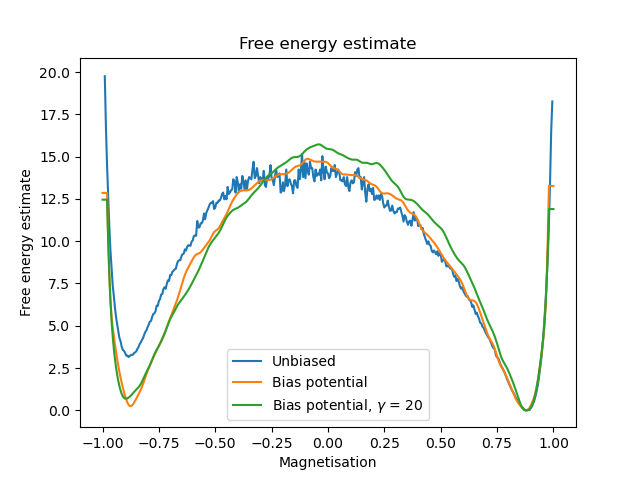

In [357]:
# Plot the free energy from the unbiased simulation
plt.close()
plt.figure()
plt.title('Free energy estimate')
plt.xlabel('Magnetisation')
plt.ylabel('Free energy estimate')
hist, bin_edges = np.histogram(M_time_series_unbiased, bins = bin_edges_of_M_domain, density = True)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
# Remove elements equal to zero from hist and bin_centers
bin_centers = bin_centers[hist!=0]
hist = hist[hist!=0]
# Assert that no element of hist is zero
assert np.all(hist!=0)
# Assert that bin_centers are the same as M_domain

free_energy_estimate = -kbT*np.log(hist)
# Compute the error on the free energy estimate
free_energy_error = kbT/np.sqrt(hist*len(M_time_series_unbiased)) # !! is this correct??
## !! is this correct??

plt.plot(bin_centers, free_energy_estimate- np.min(free_energy_estimate), label = 'Unbiased')
# Plot errors with lighter colors
plt.fill_between(bin_centers, free_energy_estimate-free_energy_error- np.min(free_energy_estimate), free_energy_estimate+free_energy_error- np.min(free_energy_estimate), alpha = 0.5)
# Plot bias
plt.plot(M_domain, -bias+np.max(bias), label = 'Bias potential')
# Plot WT bias 
plt.plot(M_domain, -bias_wt+np.max(bias_wt), label = 'Bias potential, $\gamma$ = 20')

plt.legend()

plt.show()


In [358]:
# Define where convergence is obtained
convergence = int(5e4) # Multiply by 100 to get the number of steps, since we save every 100 steps


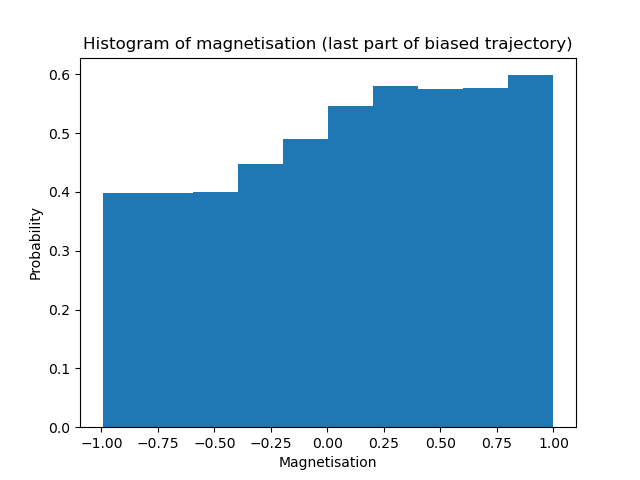

In [359]:
plt.close()
# Let's see the histrogram of the last part of biased trajectory, we expect it to be approximately flat
plt.figure()
plt.title('Histogram of magnetisation (last part of biased trajectory)')
plt.xlabel('Magnetisation')
plt.ylabel('Probability')
# Plot the histogram of the last part of the biased trajectory
plt.hist(M_time_series[convergence:], density=True)
plt.show()

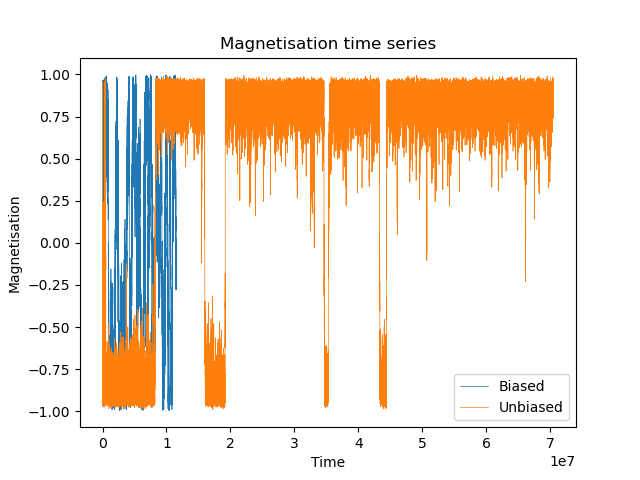

In [360]:
plt.close()
# Let's look at the trajectories of the magnetisation
plt.figure()
plt.title('Magnetisation time series')
plt.xlabel('Time')
plt.ylabel('Magnetisation')
plt.plot(np.array(range(len(M_time_series)))*100, M_time_series, label = 'Biased', linewidth=0.5)
plt.plot(np.array(range(len(M_time_series_unbiased)))*100,M_time_series_unbiased, label = 'Unbiased', linewidth=0.5)
# Multiply xlabels by 10000 to get time in steps
plt.legend()
plt.show()

In [361]:
# Block analysis of the magnetisation time series
def single_block_analysis(t_series, n_blocks):
    ''' Performs a block analysis of the time series t_series for a single value of n_blocks.
    Returns the mean and the standard deviation of the blocks. '''
    # Compute the length of each block
    N = len(t_series)
    # Split the time series with np.array_split
    blocks = np.array_split(t_series, n_blocks)
    # Compute the mean and the standard deviation of each block
    means = np.array([np.mean(block) for block in blocks])
    # Compute the mean of the means and the standard deviation of the means
    mean_of_means = np.mean(means)
    error = np.std(means)/np.sqrt(n_blocks)
    return mean_of_means, error

def block_analysis(t_series, list_of_n_blocks):
    # Let's perform a block analysis of the magnetisation time series spanning on n_blocks
    list_of_means = []
    list_of_errors = []
    # We use a set to avoid repetitions
    for n_blocks in list_of_n_blocks:
        mean_of_means, error = single_block_analysis(t_series, n_blocks)
        # Plot the error as a function of the number of blocks
        list_of_means.append(mean_of_means)
        list_of_errors.append(error)

    return list_of_means, list_of_errors

In [362]:
# Let's perform a block analysis of the magnetisation time series spanning on n_blocks
t_series = M_time_series[convergence:]
# We use a set to avoid repetitions
list_of_n_blocks = list(set(np.geomspace(1, len(t_series), 100, dtype=int)))
# Block analysis
means_M_ts, errors_M_ts = block_analysis(t_series, list_of_n_blocks)

# Same for the unbiased time series
t_series = M_time_series_unbiased[convergence:]
means_M_ts_unbiased, errors_M_ts_unbiased = block_analysis(t_series, list_of_n_blocks)

# Same for WT
t_series = M_time_series_wt[convergence:]
means_M_ts_wt, errors_M_ts_wt = block_analysis(t_series, list_of_n_blocks)


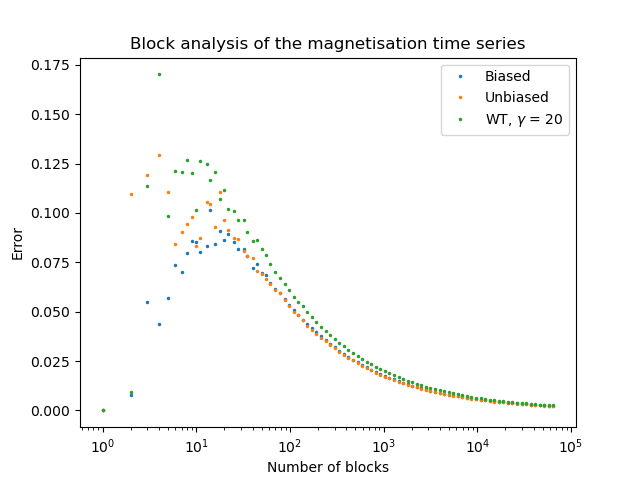

In [363]:
plt.figure()
plt.title('Block analysis of the magnetisation time series')
plt.plot(list_of_n_blocks, errors_M_ts, linestyle='None', marker='.', markersize=3, label = 'Biased')
plt.plot(list_of_n_blocks, errors_M_ts_unbiased, linestyle='None', marker='.', markersize=3, label = 'Unbiased')
plt.plot(list_of_n_blocks, errors_M_ts_wt, linestyle='None', marker='.', markersize=3, label = 'WT, $\gamma$ = 20')
plt.xscale('log')
plt.xlabel('Number of blocks')
plt.ylabel('Error')
plt.legend()
plt.show()

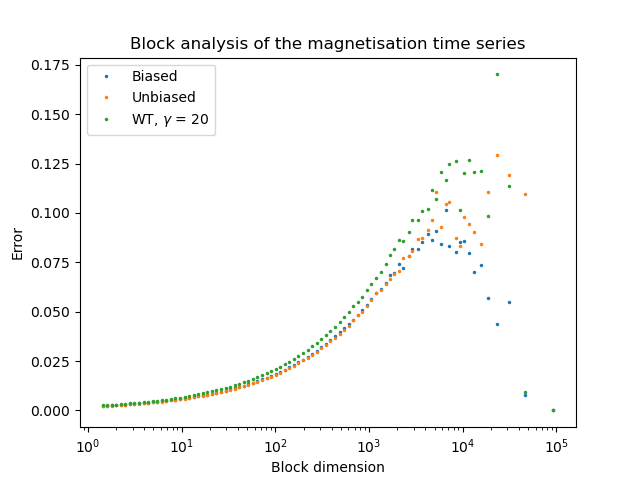

In [364]:
# Do same plot with block dimension instead of number of blocks
plt.figure()
plt.title('Block analysis of the magnetisation time series')
plt.plot(len(t_series)/np.array(list_of_n_blocks), errors_M_ts, linestyle='None', marker='.', markersize=3, label = 'Biased')
plt.plot(len(t_series)/np.array(list_of_n_blocks), errors_M_ts_unbiased, linestyle='None', marker='.', markersize=3, label = 'Unbiased')
plt.plot(len(t_series)/np.array(list_of_n_blocks), errors_M_ts_wt, linestyle='None', marker='.', markersize=3, label = 'WT, $\gamma$ = 20')
plt.xscale('log')
plt.xlabel('Block dimension')
plt.ylabel('Error')
plt.legend()
# Array with block dimension

plt.show()

In [365]:
# Plot B_time_series
B_time_series = np.loadtxt('B_time_series.txt')
plt.figure()
plt.title('Bias potential - bias average in M = 0.7')
plt.xlabel('time')
plt.ylabel('Bias potential')
plt.gca().invert_yaxis()


plt.plot(B_time_series ,linestyle = 'None', marker = '.', markersize = .1, label = 'Non-wt')
# Same for Wt
B_time_series_wt = np.loadtxt('B_time_series_gamma20.txt')
plt.plot(B_time_series_wt, label = 'Bias potential, $\gamma$ = 20', linestyle = 'None', marker = '.', markersize = .1)
plt.legend()
plt.savefig('bias_potential_time_series.png')
plt.close()

In [366]:
# Perform a block analysis of B_time_series
t_series = B_time_series
list_of_n_blocks = list(set(np.geomspace(1, len(t_series), 100, dtype=int)))
means_B_ts, errors_B_ts = block_analysis(t_series, list_of_n_blocks)

# Same for the WT time series
t_series = B_time_series_wt
means_B_ts_wt, errors_B_ts_wt = block_analysis(t_series, list_of_n_blocks)

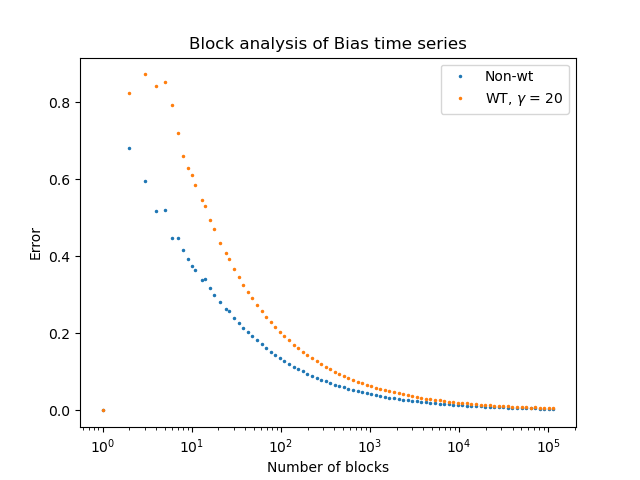

In [367]:
# Plot the block analysis of B_time_series
plt.figure()
plt.title('Block analysis of Bias time series')
plt.plot(list_of_n_blocks, errors_B_ts, linestyle='None', marker='.', markersize=3, label = 'Non-wt')
plt.plot(list_of_n_blocks, errors_B_ts_wt, linestyle='None', marker='.', markersize=3, label = 'WT, $\gamma$ = 20')
plt.xscale('log')
plt.xlabel('Number of blocks')
plt.legend()
plt.ylabel('Error')
plt.show()

In [368]:
# Close all figures
#plt.close('all')